# Data Augmentation Practice

### Read in Sample Images

In [1]:
# !pip install torchvision

In [2]:
# Imports
import torch
import numpy as np
from PIL import Image
from torchvision import transforms

# Load Image
sample_img_png = Image.open("Inputs/mr_marmot_32x32.jpg")
sample_img_png_2 = Image.open("Inputs/mr_chipmunk_32x32.jpg")

# This Image is 32x32, But Might Need to Add Resize Code Here

# Convert Image to Tensor for MixUp and CutMix
### Define Function to Convert Image to Tensor
convert_img_to_tensor = transforms.Compose([transforms.ToTensor()])

### Call Function, Output of a 32x32 is (3, 32, 32).
sample_img_tensor = convert_img_to_tensor(sample_img_png)
sample_img_tensor_2 = convert_img_to_tensor(sample_img_png_2)
batch_images = torch.stack([sample_img_tensor, sample_img_tensor_2]) 

# Find Mean and Standard Deviation to Normalize With
batch_images_flat = batch_images.view(batch_images.size(0), -1)
mean = batch_images_flat.mean(dim=1)
std = batch_images_flat.std(dim=1)
overall_mean = mean.mean(dim=0)
overall_std = std.mean(dim=0)

# Normalize Values
normalize_tensor = transforms.Compose([transforms.Normalize(mean=overall_mean.tolist(), std=overall_std.tolist())])
sample_img_tensor = normalize_tensor(sample_img_tensor)
sample_img_tensor_2 = normalize_tensor(sample_img_tensor_2)

# Create a Batch of Images
batch_images = torch.stack([sample_img_tensor, sample_img_tensor_2]) 

# Reduce Saturation using Min-Max Normalization
min_val = torch.min(batch_images)
max_val = torch.max(batch_images)
# Normalizing to [0, 1]
batch_images = (batch_images - min_val) / (max_val - min_val + 1e-7)  # Adding epsilon to prevent division by zero

# Define Labels
labels = torch.tensor([0, 1])

### Implementing MixUp

Create a blended image of two individual examples and take a weighted average of their labels.

In [3]:
"""
Create MixUp Function
    x = Tensor Inputs
    y = Labels
    Higher Alpha = More Mixing
"""
def apply_mixup(x, y, alpha):
    if alpha > 0:
        # Sample from Beta distribution to get mixing coefficient. 
        mixup_lambda = torch.distributions.Beta(alpha, alpha).sample().item()
    else:
        # Don't Mix.
        mixup_lambda = 1 
        
    # Note that 4D Tensor is Typically x.size(batch_size, channels, height, width).
    batch_size = x.size(0)
    
    # Randomly Shuffles Index Matches using Built-in Torch Function
    index = torch.randperm(batch_size)  

    # Mix the Images
    mixed_x = mixup_lambda * x + (1 - mixup_lambda) * x[index, :]
    
    # Clip Pixel Value Range
    mixed_x = np.clip(mixed_x, 0, 1)

    # Labels for Both Original and Mixed Data
    y_orig, y_mixed = y, y[index]

    # Return Images, Labels, and Lambda
    return mixed_x, y_orig, y_mixed, mixup_lambda

### Output MixUp Example Result

In [4]:
# Call Apply Mixup
mixed_img_tensor, y_orig, y_mixed, mixup_lambda = apply_mixup(batch_images, labels, alpha=0.5)

# Convert Returned Tensor to Image
mixed_img_single = mixed_img_tensor[0]
convert_tensor_to_img = transforms.ToPILImage()
mixed_img = convert_tensor_to_img(mixed_img_single)

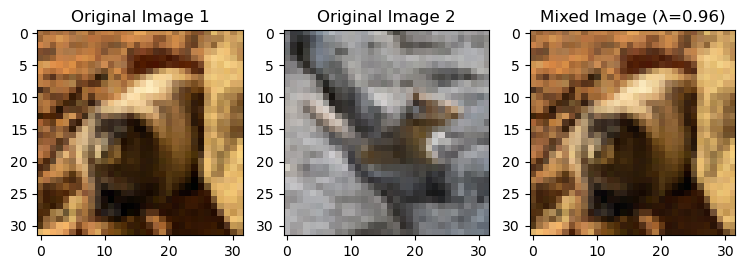

In [5]:
# Imports
import matplotlib.pyplot as plt

# Compare Original Images to Mixed Image
plt.figure(figsize=(9, 3))

### First Original Image
plt.subplot(1, 3, 1)
plt.title("Original Image 1")
plt.imshow(sample_img_png)

### Second Original Image
plt.subplot(1, 3, 2)
plt.title("Original Image 2")
plt.imshow(sample_img_png_2)

### Mixed Image
plt.subplot(1, 3, 3)
plt.title(f"Mixed Image (λ={mixup_lambda:.2f})")
plt.imshow(mixed_img)
plt.show()

Written by Kailey Quesada with the help of generative AI. It appears to have pulled from the following repository: https://github.com/facebookresearch/mixup-cifar10/blob/main/train.py.